0                 NOVA
1                 PMFS
2               KILLER
3    SplitFS-FILEBENCH
4             EXT4-DAX
5              XFS-DAX
Name: file_system, dtype: object


'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


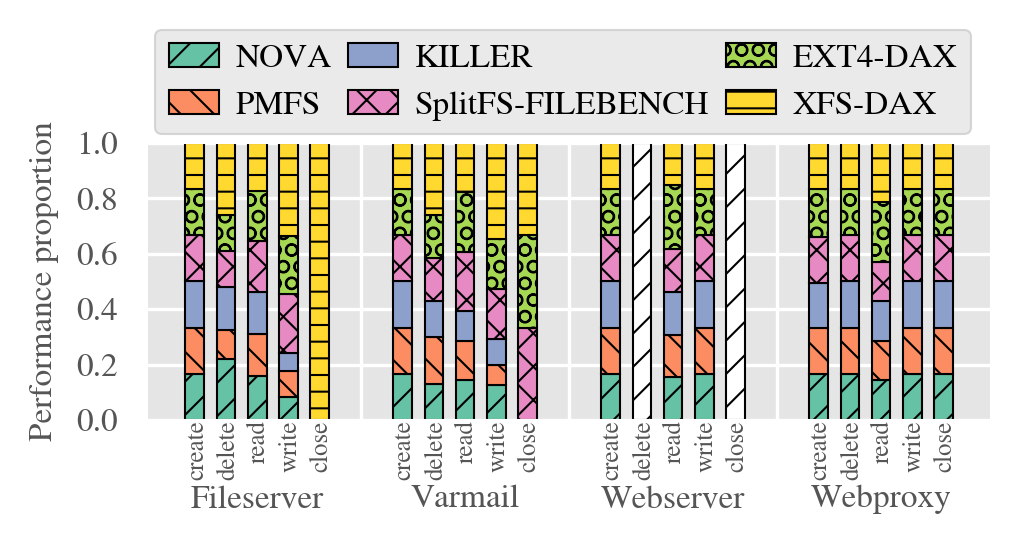

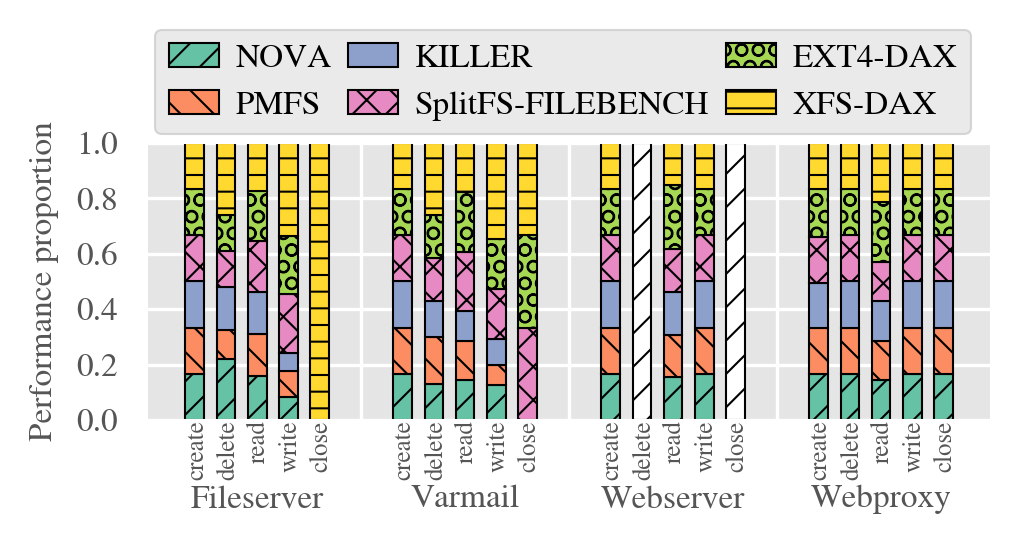

In [68]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import pandas as pd

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
style.use('ggplot')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["grid.linewidth"] = 0.8
plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams['hatch.linewidth'] = 0.5
pd.options.display.max_columns = None
pd.options.display.max_rows = None
# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

# Plotting Settings
# fig,ax = plt.subplots()
# fig.set_size_inches(cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(4))
# fig.set_dpi(300)
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(4)))


bar_width = 0.15
# patterns = ['..', '//', '\\\\', 'XX', '']
# Reference: https://designbro.com/blog/inspiration/color-combinations/
# colors = ["#1d3557", "#457b9d", "#a8dadc", "#e63946", "#f1faee"] 
# colors.reverse()
# times = ["allocate", "update-meta", "update-dram", "write-data", "other"]
patterns = ['///', '\\\\\\', '', 'XXX', 'OOO', '---', '+++']
workloads = ["fileserver.f", "varmail.f", "webserver.f", "webproxy.f"]
times = ["create", "delete", "read", "write", "close"]
x = [1, 2, 3, 4]
fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
tot = len(times) * bar_width


def normalize_workload_attr(df, workload: str, attr: str):
    if df[(df['file_bench'] == workload) & (df['threads'] == 1)][attr].sum() == 0:
        return 
    else:
        value = df[(df['file_bench'] == workload) & (df['threads'] == 1)][attr] / df[(df['file_bench'] == workload) & (df['threads'] == 1)][attr].sum()
    df.loc[(df['file_bench'] == workload) & (df['threads'] == 1), attr] = value

for workload in workloads:
    normalize_workload_attr(df, workload, "create")
    normalize_workload_attr(df, workload, "delete")
    normalize_workload_attr(df, workload, "read")
    normalize_workload_attr(df, workload, "write")
    normalize_workload_attr(df, workload, "close")

global_points = []
print(fss)
for time_idx, time in enumerate(times):
    for workload_idx, workload in enumerate(workloads):
        point = x[workload_idx] - tot / 2 + bar_width / 2 + time_idx * bar_width
        bottom = 0
        all_zero = True
        for fs_idx, fs in enumerate(fss):
            height = df[(df['file_system'] == fs) & (df['file_bench'] == workload) & (df['threads'] == 1)][time].iloc[0]
            if height != 0:
                all_zero = False
            plt.bar(point, height=height, width=bar_width * 0.6, hatch=patterns[fs_idx], edgecolor='black', color=plt.get_cmap('Set2')(fs_idx), bottom=bottom, linewidth=0.5)
            bottom += height

        if all_zero == True:
            plt.bar(point, height = 1, width=bar_width * 0.6, hatch='///', edgecolor='black', color='white', bottom=0, linewidth=0.5)
        
        global_points.append((point + 0.01, workload, time))
        
# Draw title
plt.xticks([1, 1.5, 2, 2.5, 3, 3.5, 4], labels=["Fileserver", " ", "Varmail", " ", "Webserver", " ", "Webproxy"], fontsize=8)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=8)
plt.ylim((0,1))
plt.ylabel('Performance proportion', fontsize=8)

# plt.xlabel("File Size (GiB)", fontsize=8) 

fig.legend(fss, loc='center', bbox_to_anchor=(0.55, 1.01), ncol=3, fontsize=8, columnspacing=0.5, handletextpad=0.5, handlelength=1.5)


ax = plt.gca()

# ax.xaxis.set_minor_locator(MultipleLocator(0.5))
# print([p[2] for p in global_points])
# ax.set_xticks([1, 1,5, 2, 2.5, 3, 3.5, 4], minor=False)
ax.set_xticks([p[0] for p in global_points], minor=True)
ax.set_xticklabels([p[2] for p in global_points], minor=True, fontsize=6, rotation=90, ha='center', va='top', y=0.08)
ax.tick_params(which='both', bottom=False, top=False, left=False, right=False)
ax.tick_params(axis='x', which='major', pad=(12))

plt.tight_layout()
plt.savefig("./FIG-OverheadsBreakdown-GGPlot.pdf", bbox_inches='tight', pad_inches=0)
plt.show()
